In [1]:
import numpy as np
from astropy import units as u
from astropy.constants import m_e, a0, e, c
from scipy.integrate import solve_ivp
from scipy.fft import fft as fft
from scipy.fft import fftfreq as fftfreq
import matplotlib.pyplot as plt

In [2]:
#Constants
alpha = 1/137 #fine structure constant ke^2/(h_bar*c)

#Convert from bohr radius if desired
l0 = a0.to(u.cm)
t0 = (a0/c).to(u.s) 
v0 = l0/t0 #velocity scale
acc0 = v0/t0 #acceleration scale
print(l0, t0, v0, acc0)

5.2917721090299995e-09 cm 1.7651451755434086e-19 s 29979245800.0 cm / s 1.698401140901668e+29 cm / s2


In [3]:
#Define function for numerical integration
def electron_path(t, y, Z):
    alpha = 1/137
    x, vx, y, vy  = y
    return np.asarray([vx, -Z*alpha**2*(x/((x*x)+(y*y))**(3/2)), vy, -Z*alpha**2*(y/((x*x)+(y*y))**(3/2))])

# Calculate the acceleration as a function of time in the x and y direction 
def acceleration_x(x,y, Z):
    alpha = 1 / 137
    return acc0*-Z*alpha**2*(x/((x*x)+(y*y))**(3/2)) 

def acceleration_y(x,y,Z):
    alpha = 1 / 137
    return acc0 * -Z * alpha ** 2 * (y / ((x * x) + (y * y)) ** (3 / 2))

In [21]:
# Set somem initial condictions for the particle 
# y0_index = [0, 1, 2, 3]
# y0 = [x_initial, v_x_initial, y_initial, v_y_initial] 
y0 = [-1000.,1e-3, 100., -1e-3]

# Use scipy.integrate.solve_ivp to integrate
# solve_ivp(functions to integrate, time span over integrate, initial conditions, other arguments for function, steps)
t_eval = np.linspace(0, 3e6, 10000)
solution = solve_ivp(electron_path, t_span=[0,3e6], y0=y0, args=(1,), max_step=1e2, t_eval=t_eval)
print(solution)

  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 0.000e+00  3.000e+02 ...  3.000e+06  3.000e+06]
        y: [[-1.000e+03 -9.997e+02 ...  2.153e+03  2.154e+03]
            [ 1.000e-03  1.000e-03 ...  1.052e-03  1.052e-03]
            [ 1.000e+02  9.970e+01 ... -2.706e+03 -2.706e+03]
            [-1.000e-03 -1.000e-03 ... -9.042e-04 -9.042e-04]]
      sol: None
 t_events: None
 y_events: None
     nfev: 180014
     njev: 0
      nlu: 0


[ 5.29177211e-07  5.27589519e-07  5.26001825e-07 ... -1.43171587e-05
 -1.43185943e-05 -1.43200300e-05] cm


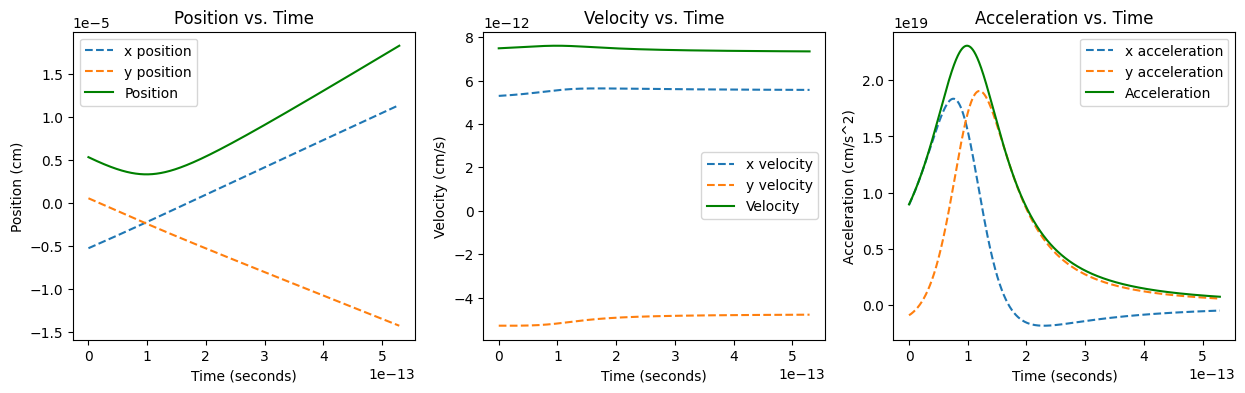

In [22]:
#Plotting Results
fig, ax = plt.subplots(nrows=1, ncols=3, figsize = (15,4))

#Position 
print(l0*solution.y[2])
ax[0].plot(t0*solution.t, l0*solution.y[0], ls = 'dashed', label = 'x position')
ax[0].plot(t0*solution.t, l0*solution.y[2], ls = 'dashed', label = 'y position')
x_total = np.sqrt( (l0*solution.y[0])**2 + (l0*solution.y[2])**2)
ax[0].plot(t0*solution.t, x_total, 'g', label = 'Position')

#Velocity 
ax[1].plot(t0*solution.t, l0*solution.y[1], ls = 'dashed', label = 'x velocity')
ax[1].plot(t0*solution.t, l0*solution.y[3], ls = 'dashed', label = 'y velocity')
v_total = np.sqrt( (l0*solution.y[1])**2 + (l0*solution.y[3])**2)
ax[1].plot(t0*solution.t, v_total, 'g', label = 'Velocity')

#Now plot ax as a function of time and ay as a function of time
ax[2].plot(t0*solution.t, acceleration_x(solution.y[0], solution.y[2], 1), ls = 'dashed', label='x acceleration')
ax[2].plot(t0*solution.t, acceleration_y(solution.y[0], solution.y[2], 1), ls = 'dashed', label='y acceleration')

a_total = np.sqrt( (acceleration_x(solution.y[0], solution.y[2], 1))**2 + (acceleration_y(solution.y[0], solution.y[2], 1)**2))
ax[2].plot(t0*solution.t, a_total, 'g', label='Acceleration')


#Axis labels, limits, titles and legends
ax[0].legend()
ax[1].legend()
ax[2].legend()
ax[0].set_xlabel('Time (seconds)')
ax[0].set_ylabel('Position (cm)')
ax[1].set_xlabel('Time (seconds)')
ax[1].set_ylabel('Velocity (cm/s)')
ax[2].set_xlabel('Time (seconds)')
ax[2].set_ylabel('Acceleration (cm/s^2)')
ax[0].set_title('Position vs. Time')
ax[1].set_title('Velocity vs. Time')
ax[2].set_title('Acceleration vs. Time')
#ax[0].set_xlim(1e-13,2e-13)
#ax[1].set_xlim(1e-13,2e-13)
#ax[2].set_xlim(1e-13,2e-13)

fig.savefig('position_velocity_acceleration.png', format = 'png')

Text(0.5, 1.0, 'x position vs. y position')

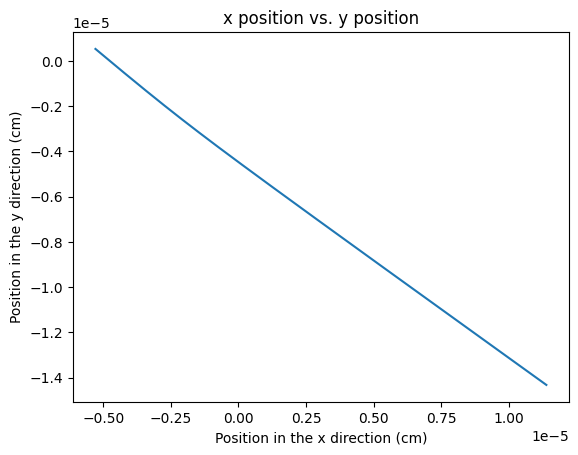

In [23]:
plt.plot(l0*solution.y[0], l0*solution.y[2])
plt.xlabel('Position in the x direction (cm)')
plt.ylabel('Position in the y direction (cm)') 
plt.title('x position vs. y position')

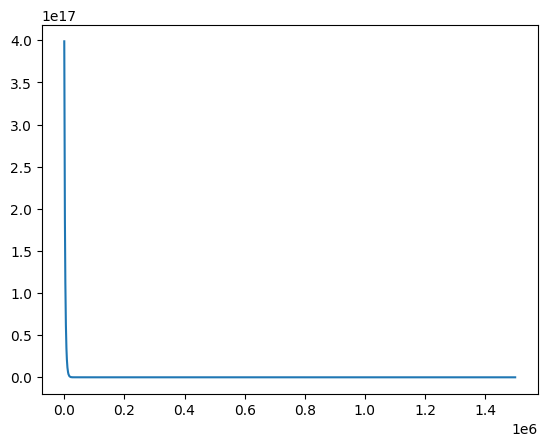

In [8]:
#Now we will do the fourier transform to find the power spectrum using numpy.fft 

N = len(solution.y[0])
T = 1/solution.t[-1]
x = np.linspace(0.0, N*T, N, endpoint=False)
#y = a_total
fourier_trans = fft(a_total)
xf = fftfreq(N, T)[:N//2] #
#print(fourier_trans)

plt.plot(xf, T * np.abs(fourier_trans[:N//2])) #0:N//2
#plt.xlim([0, 10000])
#plt.yscale('log')

In [ ]:
a_omega = (T/N)*fourier_trans
constants = (8*np.pi*
power_spectrum = (

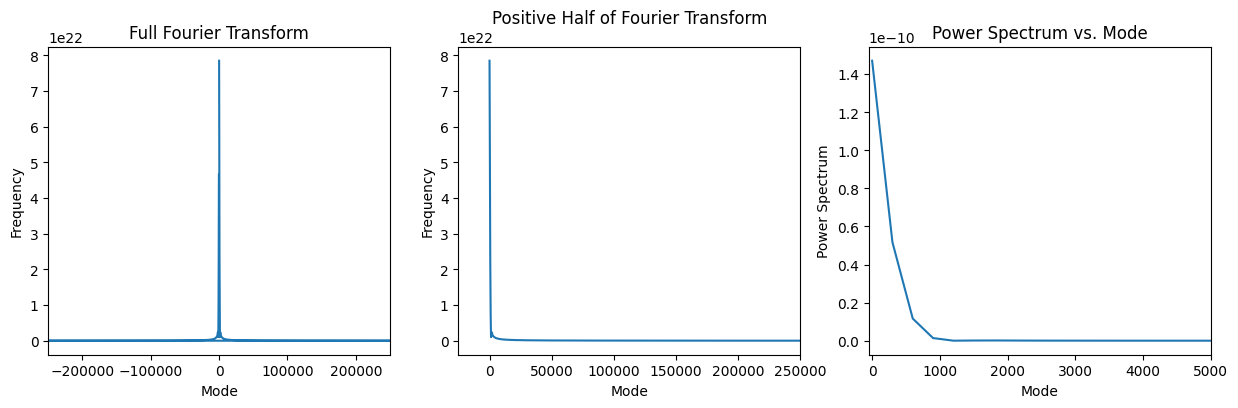

In [24]:
#Now we will do the fourier transform to find the power spectrum using numpy.fft 
#I will look at the full fourier transfer and just the positive half

N = len(solution.y[0])
T = 1/solution.t[-1]
x = np.linspace(0.0, N*T, N, endpoint=False)
fourier_trans = fft(a_total)
xf = fftfreq(N, T) #[:N//2] #
xf_positive = fftfreq(N, T)[:N//2]

# Calculate the Power Spectrum
a_omega = T*fourier_trans
#print(len(a_omega))
c = 3E10
constants = (8*np.pi*(e.gauss.value)**2)/(3*(c)**3)
power_spectrum = constants*(1/T)*np.abs(a_omega**2)

fig, ax = plt.subplots(nrows=1, ncols=3, figsize = (15,4))
ax[0].plot(xf, np.abs(fourier_trans)) #[:N//2]) 
ax[1].plot(xf_positive, np.abs(fourier_trans)[:N//2])
ax[2].plot(xf_positive, power_spectrum[:N//2])

#Axis labels, limits, and titles
ax[0].set_xlabel('Mode')
ax[0].set_ylabel('Frequency')
ax[0].set_xlim(-0.25e6, 0.25e6)
ax[0].set_title('Full Fourier Transform')
ax[1].set_xlabel('Mode')
ax[1].set_ylabel('Frequency')
ax[1].set_xlim(-0.25e5, 0.25e6)
ax[1].set_title('Positive Half of Fourier Transform')

ax[2].set_xlim(-50,5000)
ax[2].set_xlabel('Mode')
ax[2].set_ylabel('Power Spectrum')
ax[2].set_title('Power Spectrum vs. Mode')

fig.savefig('fourier_transform.png', format='png')

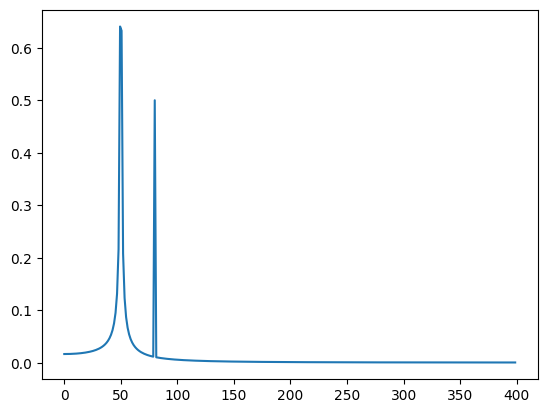

In [18]:
#Scratch Work -> not part of solution 
# Testing fft and fftfreq functions
N = 600
# sample spacing
T = 1.0 / 800.0
x = np.linspace(0.0, N*T, N, endpoint=False)
y = np.sin(50.0 * 2.0*np.pi*x) + 0.5*np.sin(80.0 * 2.0*np.pi*x)
yf = fft(y)
xf = fftfreq(N, T)[:N//2]

plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]))

In [20]:
print(e.value)

1.602176634e-19
